In [1]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib . pyplot as plt
import xml. etree . ElementTree as ET
import skimage . transform as transform
from skimage . transform import resize
from skimage import feature
from sklearn .svm import SVC
from sklearn . preprocessing import LabelEncoder
from sklearn . preprocessing import StandardScaler
from sklearn . model_selection import train_test_split
from sklearn . metrics import accuracy_score

In [2]:
annotations_dir = '/kaggle/input/traffic-sign/annotations'
img_dir = '/kaggle/input/traffic-sign/images'
img_lst = []
label_lst = []

In [3]:
for xml_file in os.listdir( annotations_dir ) :
 xml_filepath = os.path.join( annotations_dir , xml_file )
 # Parse file XML 
 tree = ET.parse(xml_filepath)
 root = tree.getroot()

 # Lấy thông tin file ảnh
 folder = root.find('folder').text
 img_filename = root.find('filename').text
 img_filepath = os.path.join(img_dir, img_filename)
 img = cv2.imread(img_filepath)

 # Lặp qua các object
 for obj in root.findall('object'):

   # Lấy tên lớp
   classname = obj.find('name').text

   # Loại bỏ class trafficlight
   if classname == 'trafficlight':
     continue 

   # Lấy box
   xmin = int(obj.find('bndbox/xmin').text)
   ymin = int(obj.find('bndbox/ymin').text)
   xmax = int(obj.find('bndbox/xmax').text)
   ymax = int(obj.find('bndbox/ymax').text)

   # Cắt object
   object_img = img[ymin:ymax, xmin:xmax]
  
   # Thêm vào list
   img_lst.append(object_img)
   label_lst.append(classname) 

print("Số lượng objects:", len(img_lst))
print("Các lớp:", list(set(label_lst)))

Số lượng objects: 1074
Các lớp: ['crosswalk', 'stop', 'speedlimit']


In [4]:

def preprocess_img(img):
  # Chuyển ảnh về grayscale nếu là ảnh màu
  if len(img.shape) > 2:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Chuyển về dạng float32
  img = img.astype(np.float32)

  # Resize ảnh về kích thước chuẩn
  resized_img = resize(img,
                       output_shape=(32, 32),
                       anti_aliasing=True)

  # Trích xuất đặc trưng HOG
  hog_feature = feature.hog( 
      resized_img,
      orientations=9,
      pixels_per_cell=(8, 8),
      cells_per_block=(2, 2),
      transform_sqrt=True,
      block_norm="L2",
      feature_vector=True
                           )
  
  # Trả về vector đặc trưng HOG
  return hog_feature

In [5]:
# Danh sách chứa các vector đặc trưng 
img_features_lst = []

# Tiền xử lý từng ảnh
for img in img_lst:
  # Trích xuất đặc trưng HOG
  hog_feature = preprocess_img(img)  
  
  # Thêm vào danh sách 
  img_features_lst.append(hog_feature)

# Chuyển sang array Numpy  
img_features = np.array(img_features_lst)
print(img_lst[0].shape)
print(img_features[0].shape)

(60, 60, 3)
(324,)


In [6]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_lst)

# Chia tập dữ liệu train/val 
random_state = 0
test_size = 0.3

X_train, X_val, y_train, y_val = train_test_split(
  img_features, encoded_labels, 
  test_size=test_size, 
  random_state=random_state,
  shuffle=True
)
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Huấn luyện SVM 
clf = SVC(kernel='rbf', 
          random_state=random_state,
          probability=True,
          C=0.5)

clf.fit(X_train, y_train)

# Đánh giá mô hình

y_pred = clf.predict(X_val)
accuracy = accuracy_score(y_pred, y_val)

print("Accuracy on validation set: ", accuracy)

Accuracy on validation set:  0.9721362229102167


In [7]:
def sliding_window(img , window_sizes , stride ,scale_factor):
    img_height ,img_width = img.shape[:2]
    windows = []
    for window_size in window_sizes:
        window_width , window_height= window_size
        window_width = int(window_width * scale_factor)
        window_height = int(window_height * scale_factor)
        for ymin in range(0,img_height - window_height +1 , stride):
            for xmin in range( 0 ,img_width - window_width +1 , stride) :
                xmax = xmin +window_width
                ymax = ymin +window_height
                
                windows.append([xmin,ymin,xmax,ymax])
    return windows

In [8]:
def pyramid(img , scale = 0.8,min_size =(30,30)):
    acc_scale = 1.0
    pyramid_imgs = [(img, acc_scale)]
    
    while True :
        acc_scale = acc_scale * scale
        h = int(img.shape[0] * acc_scale)
        w = int(img.shape[1] * acc_scale)
        if h < min_size[1] or w < min_size[0]:
            break
        img = cv2.resize(img,(w,h))
        pyramid_imgs.append((img,acc_scale))
    return pyramid_imgs

In [9]:
def visualize_bbox(img , bboxes , label_encoder):
    img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
    for box in bboxes:
#       if box.conf > confidence_threshold:
        xmin ,ymin , xmax , ymax , predict_id , conf_score = box
        
        cv2.rectangle(img , (xmin, ymin) , (xmax, ymax) ,(0,255,0),2)
        
        classname = label_encoder.inverse_transform([predict_id])[0]
        label = f"{classname} {conf_score:.2f}"
        (w,h) , _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX , 0.6 ,1)
        cv2.rectangle(img , (xmin , ymin -20) , (xmin +w ,ymin), (0,255,0) ,-1)
        
        cv2.putText(img ,label ,(xmin , ymin -5),cv2.FONT_HERSHEY_SIMPLEX ,0.6 ,(0,0,0),1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
#     cv2.imwrite('2path_to_save_image.jpg', img)
    
    

In [10]:
img_dir='/kaggle/input/traffic-sign/images'
img_filename_lst = os.listdir(img_dir)[:30]
conf_threshold =0.95
stride = 12
window_sizes =[
    (32,32) ,
    (64,64) ,
    (128 ,128)
]

In [11]:
def compute_iou(bbox, bboxes, bbox_area, bboxes_area):
    xxmin = np.maximum(bbox[0], bboxes[:, 0])
    yymin = np.maximum(bbox[1], bboxes[:, 1])
    xxmax = np.minimum(bbox[2], bboxes[:, 2])
    yymax = np.minimum(bbox[3], bboxes[:, 3])

    w = np.maximum(0, xxmax - xxmin + 1)
    h = np.maximum(0, yymax - yymin + 1)

    intersection = w * h
    iou = intersection / (bbox_area + bboxes_area - intersection)

    return iou


In [12]:
def nms(bboxes, iou_threshold):
    if not bboxes:
        return []

    scores = np.array([bbox[5] for bbox in bboxes])
    sorted_indices = np.argsort(scores)[::-1]

    xmin = np.array([bbox[0] for bbox in bboxes])
    ymin = np.array([bbox[1] for bbox in bboxes])
    xmax = np.array([bbox[2] for bbox in bboxes])
    ymax = np.array([bbox[3] for bbox in bboxes])

    areas = (xmax - xmin + 1) * (ymax - ymin + 1)

    keep = []

    while sorted_indices.size > 0:
        i = sorted_indices[0]
        keep.append(i)

        iou = compute_iou(
            [xmin[i], ymin[i], xmax[i], ymax[i]],
            np.array([
                xmin[sorted_indices[1:]],
                ymin[sorted_indices[1:]],
                xmax[sorted_indices[1:]],
                ymax[sorted_indices[1:]]
            ]).T,
            areas[i],
            areas[sorted_indices[1:]]
        )
        idx_to_keep = np.where(iou <= iou_threshold)[0]
        sorted_indices = sorted_indices[idx_to_keep + 1]

    return [bboxes[i] for i in keep]


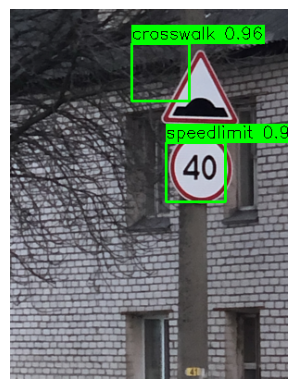

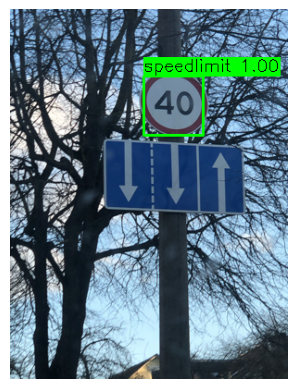

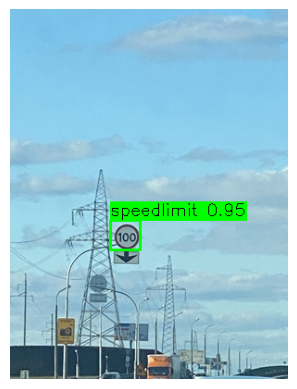

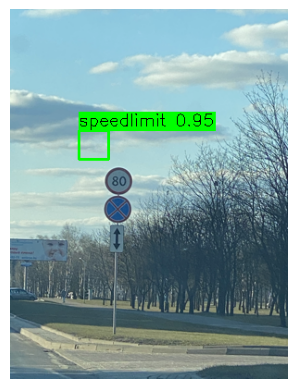

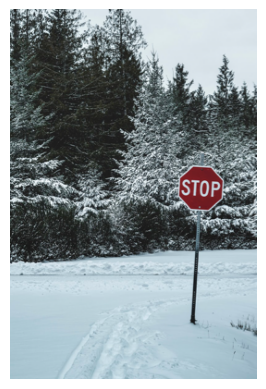

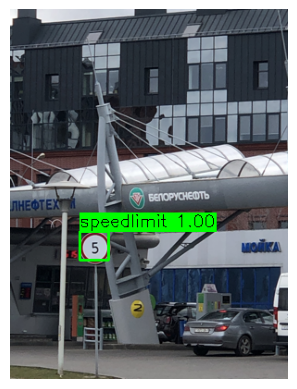

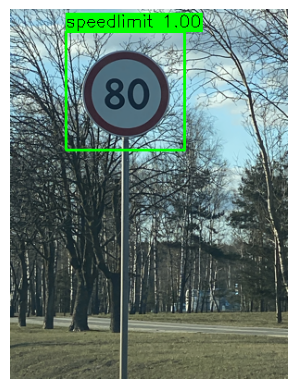

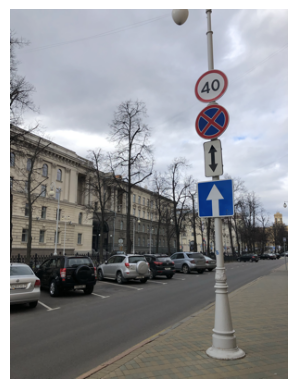

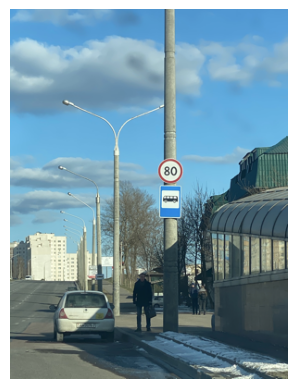

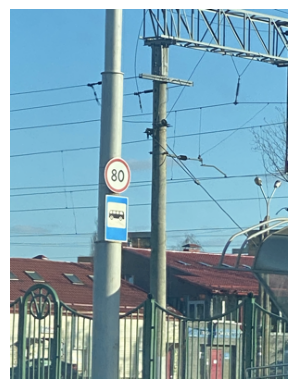

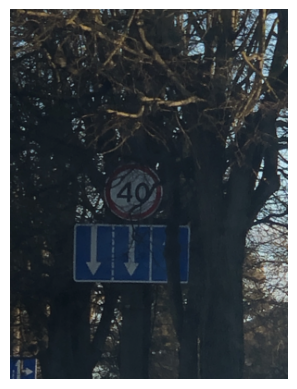

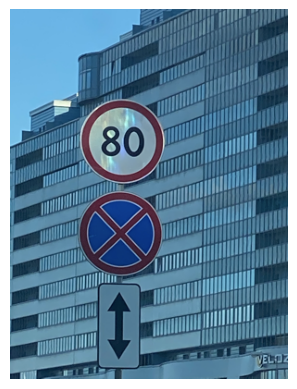

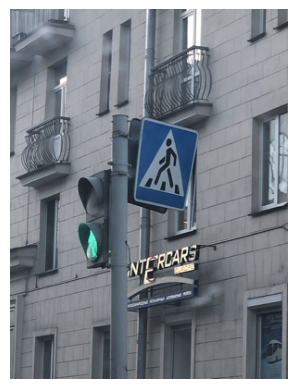

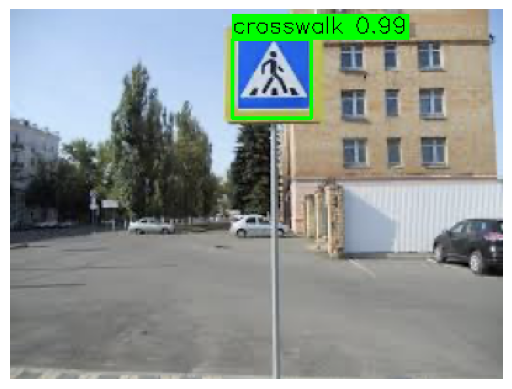

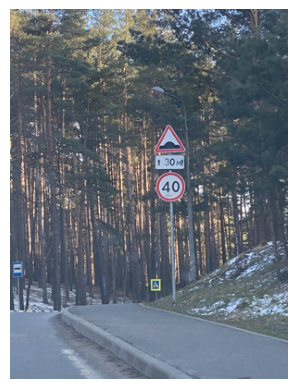

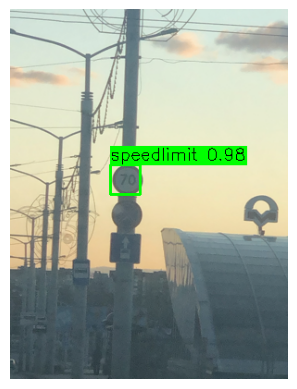

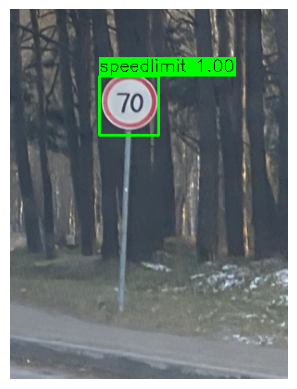

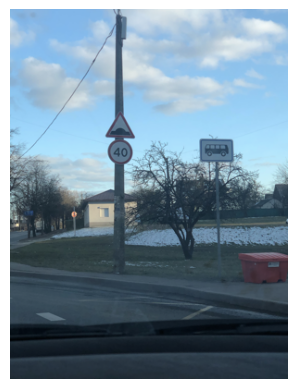

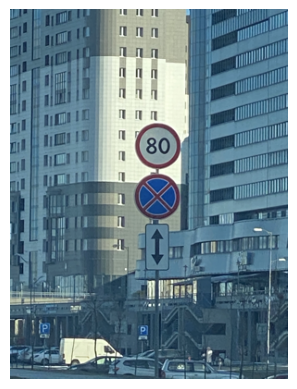

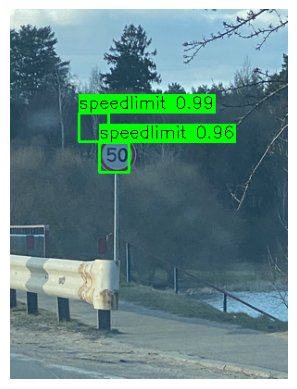

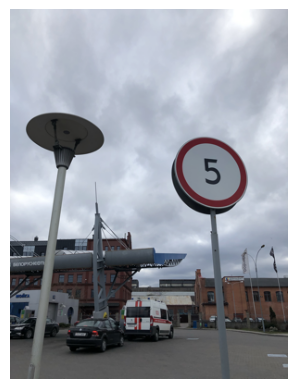

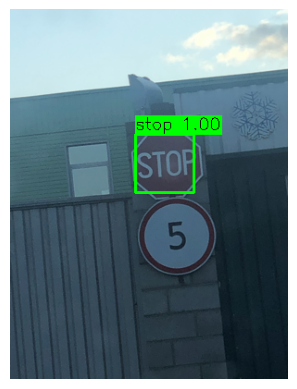

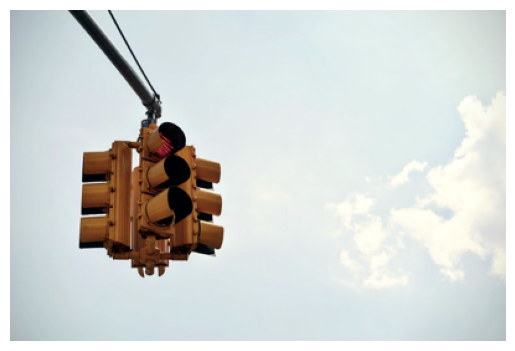

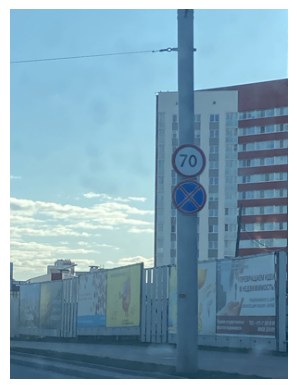

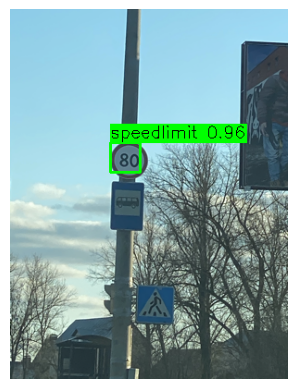

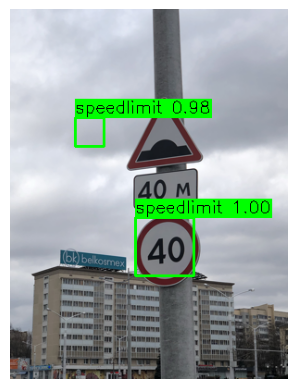

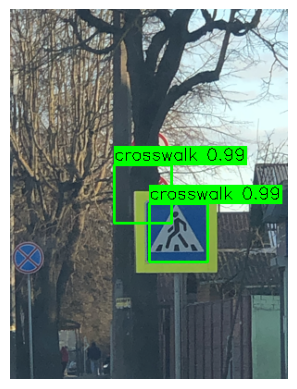

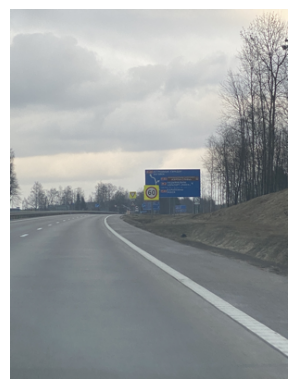

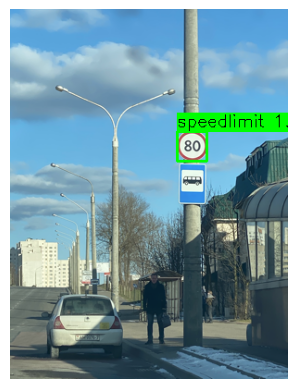

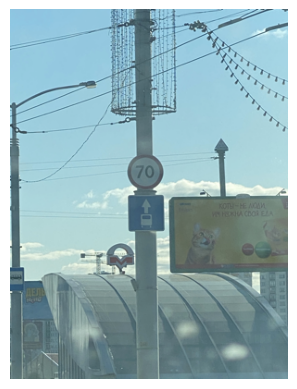

In [13]:
for img_filename in img_filename_lst:
    start_time = time.time()
    img_filepath = os.path.join(img_dir , img_filename)
    bboxes =[]
    img = cv2.imread(img_filepath)
   
    pyramid_imgs = pyramid(img)
    for pyramid_img_info in pyramid_imgs :
        pyramid_img , scale_factor = pyramid_img_info
        window_lst =sliding_window(
           pyramid_img , 
           window_sizes =window_sizes ,
           stride = stride ,
           scale_factor = scale_factor  
        )
        for window in window_lst :
            xmin , ymin , xmax ,ymax =window
            object_img = pyramid_img[ymin : ymax ,xmin : xmax]
            preprocessed_img = preprocess_img(object_img)
            normalized_img = scaler.transform([preprocessed_img])[0]
            decision = clf.predict_proba([normalized_img])[0]
            if np.all(decision < conf_threshold):
                continue
            else : 
                predict_id = np.argmax(decision)
                conf_score =decision[predict_id]
                xmin = int(xmin / scale_factor)
                ymin = int(ymin / scale_factor)
                xmax = int(xmax / scale_factor)
                ymax = int(ymax / scale_factor)
                bboxes.append(
                   [xmin ,ymin , xmax , ymax , predict_id , conf_score]
                )
    bboxes = nms(bboxes, iou_threshold=0.1)
    visualize_bbox( img,bboxes ,label_encoder)

In [14]:
# import joblib
# joblib.dump(clf, 'traffic_sign_detector_model.pkl')